# **Dependencies**

In [ ]:
import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Original Data: https://www.kaggle.com/datasets/msambare/fer2013/data

In [ ]:
!unzip /content/FER-2013-Full.zip

# **Tests**

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [ ]:
img_array = cv2.imread("/content/train/surprise/Training_72717626.jpg")
img_array.shape

(48, 48, 3)

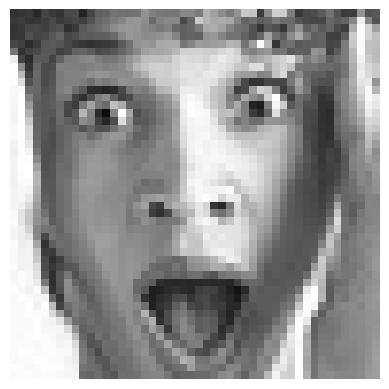

In [ ]:
plt.axis('off')
plt.imshow(img_array)

# **Data**

In [ ]:
Classes = ['angry','disgust','fear','happy','neutral','sad','surprise']
# Classes = ['happy', 'sad']
# Classes = ['happy', 'sad', 'neutral']
# Classes = ['happy', 'sad', 'angry']
# Classes = ['surprise', 'fear', 'disgust']
# Classes = ['sad', 'fear', 'angry']
# Classes = ['happy', 'sad', 'neutral', 'angry']

## **Read all images, resize, and convert into arrays**

In [ ]:
def create_data( data, Datadirectory ):
  for category in Classes:
    path = os.path.join(Datadirectory, category)
    class_num = Classes.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img) )
        #img_array = cv2.resize(img_array, (48, 48) )
        data.append( [img_array, class_num] )
      except Exception as e:
        pass

In [ ]:
training_data = []
# Datadirectory = "/content/FER2013Dataset/train"
Datadirectory = "/content/train"
create_data(training_data, Datadirectory)

In [ ]:
testing_data = []
# Datadirectory = "/content/FER2013Dataset/test"
Datadirectory = "/content/test"
create_data(testing_data, Datadirectory)

In [ ]:
print( len(training_data) )
print( len(testing_data) )

28709
7178


## **Create Training and Testing Data NumPy Arrays**

In [ ]:
def create_train_test(data, x, y):
  for features, label in data:
    x.append(features)
    y.append(label)

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

create_train_test(training_data, x_train, y_train)
create_train_test(testing_data, x_test, y_test)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

28709
28709
7178
7178


In [ ]:
X_train = np.array(x_train) / 255.0
Y_train = np.array(y_train)

In [ ]:
X_test = np.array(x_test) / 255.0
Y_test = np.array(y_test)

In [ ]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))
X_train[0].shape

22967
22967
7178
7178


(48, 48, 3)

In [ ]:
# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

##**Targeted Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# More aggressive data augmentation for underrepresented classes
datagen_underrepresented = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

augmented_data = []
augmented_labels = []

underrepresented_classes = ['angry','disgust','fear','neutral','sad','surprise']
underrepresented_indexes = [Classes.index(c) for c in underrepresented_classes]

training_data_for_aug = list(zip(X_train, Y_train))

for img, label in training_data_for_aug:
    augmented_images = []
    if label in underrepresented_indexes:
        if label == 1: # disgust
          augmented_images = [datagen_underrepresented.random_transform(img) for _ in range(15)]
        else:
          augmented_images = [datagen_underrepresented.random_transform(img)]
    augmented_data.extend(augmented_images)
    augmented_labels.extend([label] * len(augmented_images))

# Convert to numpy arrays and reshape
X_augmented = np.array(augmented_data).reshape(-1, 48, 48, 3)
Y_augmented = np.array(augmented_labels)

# Update training data with augmented data
X_train = np.concatenate((X_train, X_augmented), axis=0)
Y_train = np.concatenate((Y_train, Y_augmented), axis=0)

**Validation Included**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

original_X_train, x_val, original_Y_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Convert validation set to numpy arrays and normalize
X_val = np.array(x_val).reshape(-1, 48, 48, 3)
Y_val = np.array(y_val)

training_data_for_aug = list(zip(original_X_train, original_Y_train))

datagen_underrepresented = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_data = []
augmented_labels = []

underrepresented_classes = ['angry','disgust','fear','neutral','sad','surprise']

underrepresented_indexes = [Classes.index(c) for c in underrepresented_classes]

for img, label in training_data_for_aug:
    augmented_images = []
    if label in underrepresented_indexes:
        if label == 1: # disgust
          augmented_images = [datagen_underrepresented.random_transform(img) for _ in range(16)]
        elif label == 6: # surprise
          augmented_images = [datagen_underrepresented.random_transform(img) for _ in range(2)]
        else:
          augmented_images = [datagen_underrepresented.random_transform(img)]
    augmented_data.extend(augmented_images)
    augmented_labels.extend([label] * len(augmented_images))

# Convert augmented data to numpy arrays and normalize
X_augmented = np.array(augmented_data).reshape(-1, 48, 48, 3)
Y_augmented = np.array(augmented_labels)

# Combine original and augmented training data
X_train = np.concatenate((X_augmented, np.array(original_X_train).reshape(-1, 48, 48, 3)), axis=0)
Y_train = np.concatenate((Y_augmented, np.array(original_Y_train)), axis=0)

In [ ]:
print(np.bincount(Y_train))

[7990 6976 8194 7215 9930 9660 6342]


In [ ]:
print(np.bincount(Y_test))

[ 958  111 1024 1774 1233 1247  831]


# **Optimized Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=45,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    validation_split=0.2 # set validation split
)

# Data augmentation for validation data should only rescale
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data in batches
train_generator = train_datagen.flow_from_directory(
    directory="/content/train",
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode='sparse',
    subset='training'
)

# Load validation data in batches
validation_generator = val_datagen.flow_from_directory(
    directory="/content/train",
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode='sparse',
    subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


# **Sequential Model**

In [ ]:
model = Sequential()

# Layer 1
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                        input_shape=(48, 48, 3), data_format='channels_last',
                        kernel_regularizer=l2(0.01)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

# Layer 2
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

# Layer 3
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

# Layer 4
model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

# Flatten the layers
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

# Output layer
model.add(layers.Dense(7, activation='softmax'))

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#**EfficientNet80 Model**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Define the input shape
input_shape = (48, 48, 1)

# Create a new input layer that accepts grayscale images
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(3, (3, 3), padding='same', activation='relu')(inputs)

# Load the EfficientNetB0 model with pre-trained weights, excluding the top layers
# Use the output of the Conv2D layer as input to EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Add custom layers on top of the base model
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions
x = layers.Dense(128, activation='relu')(x)  # Fully connected layer with 128 units
x = layers.Dropout(0.1)(x)  # Dropout for regularization
outputs = layers.Dense(7, activation='softmax')(x)  # Output layer for 7 classes

# Combine the base model and custom layers into a new model
model = keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

# **Train + Test with Datagens**

In [ ]:
# Train the model
model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    shuffle=True
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.2734 - loss: 1.7783 - val_accuracy: 0.4187 - val_loss: 1.5118
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4386 - loss: 1.4667 - val_accuracy: 0.4799 - val_loss: 1.3532
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5015 - loss: 1.3054 - val_accuracy: 0.5138 - val_loss: 1.2795
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5481 - loss: 1.1806 - val_accuracy: 0.5030 - val_loss: 1.2895
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5882 - loss: 1.0914 - val_accuracy: 0.5400 - val_loss: 1.2187
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6224 - loss: 1.0042 - val_accuracy: 0.5407 - val_loss: 1.2381
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6576 - loss: 0.9057 - val_accuracy: 0.5544 - val_loss: 1.2535
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6865 - loss: 0.8335 - val_accurac

In [ ]:
# Data augmentation for test data should only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data in batches
test_generator = test_datagen.flow_from_directory(
    directory="/content/test",
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode='sparse'
)

Found 7178 images belonging to 7 classes.


In [ ]:
# Evaluate the model
model.evaluate(test_generator)

 16/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5568 - loss: 3.6210

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5417 - loss: 3.5294


[3.4672789573669434, 0.5424909591674805]

In [ ]:
# Predict the classes for the test set
Y_pred = model.predict(test_generator)

# True labels
Y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred.argmax(axis=1))

# Plot confusion matrix using seaborn
plt.figure(figsize=(11, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Classes, yticklabels=Classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Weights**

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

class_weights_dict = dict(enumerate(class_weights))

# Print class weights for inspection
print("Class weights:", class_weights_dict)

Class weights: {0: 1.0067405685678528, 1: 1.1530758519003932, 2: 0.9816764880225949, 3: 1.114879714879715, 4: 0.810056107034959, 5: 0.8326974267968057, 6: 1.2683470739289093}


#**Train + Test XY**

In [ ]:
model.fit(X_train, Y_train, epochs=30, shuffle=True)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.2221 - loss: 2.0299
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.2991 - loss: 1.7534
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4141 - loss: 1.5137
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4724 - loss: 1.3810
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5062 - loss: 1.3095
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5356 - loss: 1.2343
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5570 - loss: 1.1843
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5863 - loss: 1.1122
Epoch 9/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6182 - loss: 1.0312
Epoch 10/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6387 - loss: 0.9780
Epoch 11/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6804 - loss: 0.8934
Epoch 12/30
718/718 ━━━━━━━━━━

In [ ]:
model.fit(X_train, Y_train, epochs=30, class_weight=class_weights_dict, shuffle=True)

In [ ]:
model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), class_weight=class_weights_dict, shuffle=True)

###**Testing**

In [ ]:
model.evaluate(X_test, Y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6041 - loss: 1.9474


[1.8615436553955078, 0.6188353300094604]

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


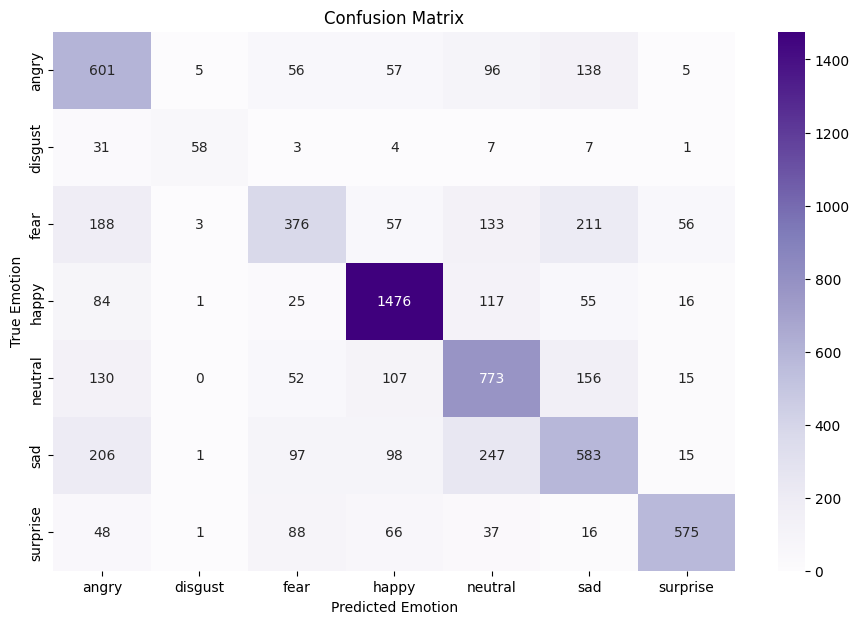

In [ ]:
y_pred = model.predict(X_test)

cm = confusion_matrix(Y_test, y_pred.argmax(axis=1))

plt.figure(figsize=(11,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=Classes, yticklabels=Classes)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(np.bincount(Y_test))

[ 958  111 1024 1774 1233 1247  831]


#**Save Model**

In [ ]:
model.save('seqfermodel3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = keras.models.load_model('seqfermodel3.h5')

#**Notes**

Model Run with 2 Categories - Happy/Sad.

*   Training Data Accuracy: 95%+
*   Test Data Accuracy: 86%
*   Training Data Size: 12045
*   Test Data Size: 3021

Model Run with 3 Categories - Happy/Sad/Neutral.

*   Training Data Accuracy: 97%+
*   Test Data Accuracy: 69%
*   Training Data Size: 17010
*   Test Data Size: 4254

Model Run with 3 Categories - Happy/Sad/Angry.

*   Training Data Accuracy: 98%+
*   Test Data Accuracy: 72%
*   Training Data Size: 16040
*   Test Data Size: 3979

Model Run with 3 Categories that are lower in dataset size- Surprise/Fear/Disgust.

*   Training Data Accuracy: 98%
*   Test Data Accuracy: 79%
*   Training Data Size: 7704
*   Test Data Size: 1966

Model Run with 3 Categories that are similar in visual style (Sad/Fear/Angry)

*   Training Data Accuracy: 97%
*   Test Data Accuracy: 54%
*   Training Data Size: 12922
*   Test Data Size: 3229


Model Run with All Categories.

*   Training Data Accuracy: 94%+
*   Test Data Accuracy: 60%
*   Training Data Size: 28709
*   Test Data Size: 7178

EfficientNet80 Model Run with All Categories.

*   Training Data Accuracy: 95%+
*   Test Data Accuracy: 60%
*   Training Data Size: 28709
*   Test Data Size: 7178


Key notes:
* Additional training data DID improve model performance. When we switched from the modified dataset to the original, test data performance improved.

* Image fidelity may play a role, where nuances in expression may not be detectible in a small image space of 48x48. Larger images require significantly more compute time on GPUs and it is always a balance

* Initial theory was that smaller datasets in categories such as Surprise, Fear and Disgust were a key driver in lower model performance in aggregate. However, on further research, these categories performed quite well (see Surprise/Fear/Disgust metric). We found the model performance is higher when a /smaller/ number of categories were included and is lower when including more categories.

* Theory: A small number of classifications (e.g. 3) can be performed with high accuracy. When a larger number of classifications are included, the overall model accuracy drops. It is easier to distinguish Happy/Sad vs a larger number of possibilieid, e.g. (Happy/Surprised/Surprised/Angry) within one model.

* Images with similar emotion visualizations (Sad, Angry, and Fearful all may have a frowning aspect) do have low test accuracy. 54% in this case. This points to the challenges in categorizing nuanced differences, while highlighting the relatively strong performance of categorizing emotions that are more visually distinct (Happy/Sad)

* The "Truthfulness" of the images should be considered, and data labeling biases may exist. What may be considered Neutral to some may look Angry to others.
